In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np
from numpy.random import default_rng
from scipy.linalg import fractional_matrix_power


# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mplimg
from matplotlib.colors import DivergingNorm, LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from cycler import cycler
from matplotlib.patches import Rectangle

# ML
from soap import compute_soap_density, reshape_soaps
from soap import rrw_neighbors, make_tuples
from soap import extract_species_pair_groups
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Utilities
import h5py
import json
import re
import project_utils as utils
from tools import load_json

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

In [3]:
#def make_plot(output, density, r_grid, p_grid, species_pair_label, neighbors=None):
# TODO: scatter points only for selected environments?
def make_plot(output, r_grid, p_grid, density, density_highlight=None,
              rrw_neighbors=None, idxs_neighbors=None, 
              species_pair_idx=None, species_pair_name=None,
              scatter=False, annotate=[]):
    
    # Camera view settings
    x = -1.25
    y = -1.25
    z = 1.25

    # Compute aspect ratio from data
    # so we can set it manually including zoom
    # TODO: make this compatible with differing r_grid and p_grid sizes
    zoom = 1.0
    aspect_ratio_keys = ['x', 'y', 'z']
    xyz_max = np.amax(np.column_stack((r_grid, r_grid, p_grid)), axis=0)
    xyz_min = np.amin(np.column_stack((r_grid, r_grid, p_grid)), axis=0)
    xyz_ratios = np.abs(xyz_max - xyz_min)
    xyz_ratios = xyz_ratios / xyz_ratios[0] * zoom
    xyz_ratios[2] *= xyz_ratios[0] / xyz_ratios[2] # Make cube

    aspect_ratio = {key: value for key, value in zip(aspect_ratio_keys, xyz_ratios)}
    
    annotations = []
    
    # Plot
    rx_grid, ry_grid, pz_grid = np.meshgrid(r_grid, r_grid, p_grid, indexing='ij')
    
    avg = np.mean(density)
    std = np.std(density)
    
    avg_highlight = np.mean(density_highlight)
    std_highlight = np.std(density_highlight)

    fig = go.Figure()
    fig.add_trace(
        go.Isosurface(
            x=rx_grid.flatten(),
            y=ry_grid.flatten(),
            z=pz_grid.flatten(),
            value=density.flatten(),
            coloraxis='coloraxis1',
            isomin=avg - 2.0*std,
            isomax=avg + 2.0*std,
            opacity=0.3,
            surface_count=4,
            caps=dict(x_show=False, y_show=False, z_show=False)
        )
    )
        
    if density_highlight is not None:
        fig.add_trace(
            go.Volume(
                x=rx_grid.flatten(),
                y=ry_grid.flatten(),
                z=pz_grid.flatten(),
                value=density_highlight.flatten(),
                coloraxis='coloraxis2',
                isomin=avg_highlight - 2.0*std_highlight,
                isomax=avg_highlight + 2.0*std_highlight,
                opacity=0.4,
                surface_count=2,
                caps=dict(x_show=False, y_show=False, z_show=False)
            )
        )

    if rrw_neighbors is not None and species_pair_idx is not None:
        atom_stencils = [[], [], []]
        for xyz in range(0, len(atom_stencils)):
            atom_stencils[xyz] = np.concatenate(
                [center[species_pair_idx][xyz].flatten() for center in rrw_neighbors]
            )

        if idxs_neighbors is not None:
            idxs = [[], [], []]
            for xyz in range(0, len(idxs)):
                idxs[xyz] = np.concatenate(
                    [center[species_pair_idx][xyz].flatten() for center in idxs_neighbors]
                )
            hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>(i, j, k): %{text}'
            hovertext = ['{}'.format(i) for i in zip(idxs[0], idxs[1], idxs[2])]
        else:
            hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}'
            hovertext=None

        if scatter:
            fig.add_trace(
                go.Scatter3d(
                    x=atom_stencils[0],
                    y=atom_stencils[1],
                    z=atom_stencils[2],
                    name=f'{species_pair_name}',
                    mode='markers',
                    marker=dict(size=5, color='purple'),
                    hovertemplate=hovertemplate,
                    text=hovertext,
                    showlegend=False
                )
            )
        
        for center in annotate:
            annotations.append(dict(
                showarrow=True,
                x=atom_stencils[0][center],
                y=atom_stencils[1][center],
                z=atom_stencils[2][center],
                hovertext=f'(i, j, k): {hovertext}',
                text=f'{center}',
                arrowcolor='Black',
                arrowsize=1,
                arrowwidth=2,
                ax=50,
                ay=-50,
                xshift=5,
                yshift=5,
            ))
                
    font_size = 18
    species_pair_title = '-'.join(re.findall('[A-Z][a-z]*', species_pair_name))
    fig.update_layout(
        template='simple_white',
        title=dict(
            text=f'Si-<b>{species_pair_title}</b>',
            font=dict(size=2.0 * font_size),
            x=0.5, y=0.85,
            xanchor='center',
            yanchor='top'
        ),
        scene=dict(
            xaxis=dict(
                title=dict(text='r', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            yaxis=dict(
                title=dict(text='r\'', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            zaxis=dict(
                title=dict(text='w', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            annotations=annotations,
            camera=dict(
                eye=dict(x=-1.25, y=-1.25, z=1.25),
                projection=dict(type='orthographic')
            ),
            aspectratio=aspect_ratio
        ),
        legend=dict(
            x=0.0, y=1.0,
            xanchor='left', yanchor='top',
            itemsizing='constant'
        ),
        coloraxis1=dict(
            colorscale='RdBu',
            colorbar=dict(
                title=dict(
                    text='Weights*Density', 
                    side='right',
                    font=dict(size=font_size)
                ),
                ticks='inside',
                tickwidth=2,
                ticklen=10,
                tickfont=dict(size=font_size),
                outlinecolor='Black',
                outlinewidth=2,
                len=0.5,
                x=-0.02, xanchor='right'
            ),
        ),
        coloraxis2=dict(
            colorscale='Purples',
            colorbar=dict(
                title=dict(
                    text='Density', 
                    side='right',
                    font=dict(size=font_size)
                ),
                ticks='inside',
                tickwidth=2,
                ticklen=10,
                tickfont=dict(size=font_size),
                outlinecolor='Black',
                outlinewidth=2,
                len=0.5
            ),
        ),
        font=dict(size=14, family='helvetica, sans-serif'),
        autosize=False, width=800, height=800,
        #margin=dict(t=5, b=5)
    )
    
    fig.show()

    fig.write_html(f'{output}.html')
    fig.write_image(f'{output}.pdf')

# Setup

## Load train and test splits

In [4]:
# Load SOAP hyperparameters
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

# Load basis hyperparameters
basis_hyperparameters = load_json('../../Processed_Data/basis_hyperparameters.json')

In [5]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_train_sort_idxs = np.argsort(iza_train_idxs)
iza_train_unsort_idxs = np.argsort(iza_train_sort_idxs)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)
iza_test_sort_idxs = np.argsort(iza_test_idxs)
iza_test_unsort_idxs = np.argsort(iza_test_sort_idxs)

In [6]:
# Load indices of DEEM 10k set in 330k
idxs_deem_10k = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [7]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)
n_deem = len(deem_cantons_2)

In [8]:
# Build set of "master" canton labels for the train set
train_cantons = {}

train_cantons[4] = np.concatenate((
    iza_cantons[iza_train_idxs], 
    deem_cantons_4[deem_train_idxs]
))

train_cantons[2] = np.concatenate((
    np.ones(len(iza_train_idxs), dtype=int),
    deem_cantons_2[deem_train_idxs]
))

train_class_weights = {
    n_cantons: utils.balanced_class_weights(train_cantons[n_cantons]) for n_cantons in (2, 4)
}

# Build set of "master" canton labels for the test set
test_cantons = {}

test_cantons[4] = np.concatenate((
    iza_cantons[iza_test_idxs], 
    deem_cantons_4[deem_test_idxs]
))

test_cantons[2] = np.concatenate((
    np.ones(len(iza_test_idxs), dtype=int),
    deem_cantons_2[deem_test_idxs]
))

test_class_weights = {
    n_cantons: utils.balanced_class_weights(test_cantons[n_cantons]) for n_cantons in (2, 4)
}

In [9]:
ticklabels = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']
}

In [10]:
# Linear model setup
n_species = 2
group_names = {
    'power': ['OO', 'OSi', 'SiSi', 'OO+OSi', 'OO+SiSi', 'OSi+SiSi', 'OO+OSi+SiSi'], 
    'radial': ['O', 'Si', 'O+Si']
}

## Grid setup

In [27]:
# Set grids
n_r_grid = 1000
chunk_size_r = 10
r_grid = {}
for cutoff in cutoffs:
    r_grid[cutoff] = np.linspace(
        0.0, cutoff + 3 * soap_hyperparameters['gaussian_sigma_constant'], n_r_grid
    )

n_p_grid = 50
chunk_size_p = 10
p_grid = np.linspace(-1.0, 1.0, n_p_grid)

## Model setup

In [28]:
# Linear model setup
n_species = 2
group_names = {
    'power': ['OO', 'OSi', 'SiSi'], #'OO+OSi', 'OO+SiSi', 'OSi+SiSi', 'OO+OSi+SiSi'], 
    'radial': ['O', 'Si', 'O+Si']
}

In [29]:
model_dir = '../../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

# Select example frameworks

In [14]:
n_random = 25

In [15]:
# Example Deem structures
deem_ex_idxs = deem_test_idxs.copy()
rng = default_rng(seed=78390)
rng.shuffle(deem_ex_idxs)
deem_ex_idxs = deem_ex_idxs[0:n_random]
deem_ex_sort_idxs = np.argsort(deem_ex_idxs)
deem_ex_unsort_idxs = np.argsort(deem_ex_sort_idxs)

# Example IZA structures
iza_ex_idxs = iza_test_idxs.copy()
rng = default_rng(seed=82437)
rng.shuffle(iza_ex_idxs)
iza_ex_idxs = iza_ex_idxs[0:n_random]
iza_ex_sort_idxs = np.argsort(iza_ex_idxs)
iza_ex_unsort_idxs = np.argsort(iza_ex_sort_idxs)

# Power spectrum

In [ ]:
for cutoff in cutoffs:
    linear_dir = f'{model_dir}/{cutoff}/LSVC'
    
    #for spectrum_type in ('power', 'radial'):
    spectrum_type = 'power'
    spectrum_name = spectrum_type.capitalize()        
        
    for gdx, group_name in enumerate(group_names[spectrum_type]):
        deem_file = f'{deem_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
        iza_file = f'{iza_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'

        # TODO: average over all Deem, average over all IZA, average over all in the train set
        # TODO: scale with the appropriate NormScaler
        hdf5_deem = h5py.File(deem_file, 'r')
        hdf5_iza = h5py.File(iza_file, 'r')

        soaps_deem = hdf5_deem['0'][:]
        soaps_iza = hdf5_iza['0'][:]

        hdf5_deem.close()
        hdf5_iza.close()

        partial_density_sod = density_sod[cutoff][:, gdx, ...]

        n_cantons = 2

        output = f'../../Results/{cutoff}/real_space_overlap_{cutoff}_{n_cantons}-class_{spectrum_type}_{group_name}'

        weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
        weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'

        hdf5_weights = h5py.File(weights_file, 'r')
        weights = hdf5_weights['0'][:]

        hdf5_weights.close()

        overlap = weights * soaps_avg

        make_plot(
            output, 
            r_grid[cutoff], p_grid,
            weights.squeeze(),
            #weights.squeeze() * partial_density_sod.squeeze(), 
            partial_density_sod.squeeze(), 
            rrw_neighbors=sod_neighbor_rrw[cutoff],
            idxs_neighbors=sod_neighbor_idxs[cutoff],
            species_pair_idx=gdx,
            species_pair_name=group_name,
            scatter=True, annotate=[]
        )

# Radial spectrum

In [16]:
def align_yaxes(axs, ref_axs, ref_value):
    axs_frac = axs.transLimits.transform([0.0, ref_value])[1]
    ref_axs_frac = ref_axs.transLimits.transform([0.0, ref_value])[1]
    
    axs_ylim = list(axs.get_ylim())
    
    # Increase y_max of axis
    if axs_frac > ref_axs_frac:
        y = (ref_value - axs_ylim[0] * (1.0 - ref_axs_frac)) / ref_axs_frac
        axs_ylim[1] = y

    # Decrease y_min of axis
    elif axs_frac < ref_axs_frac:
        y = (ref_value - axs_ylim[1] * ref_axs_frac) / (1.0 - ref_axs_frac)
        axs_ylim[0] = y

        
    return axs_ylim

[2.2899554034172893]
[0.22169114151774658]
[1.832351663697952]
[0.46252857365117006]
[0.3648512848218918]
[1.3199355413479716]


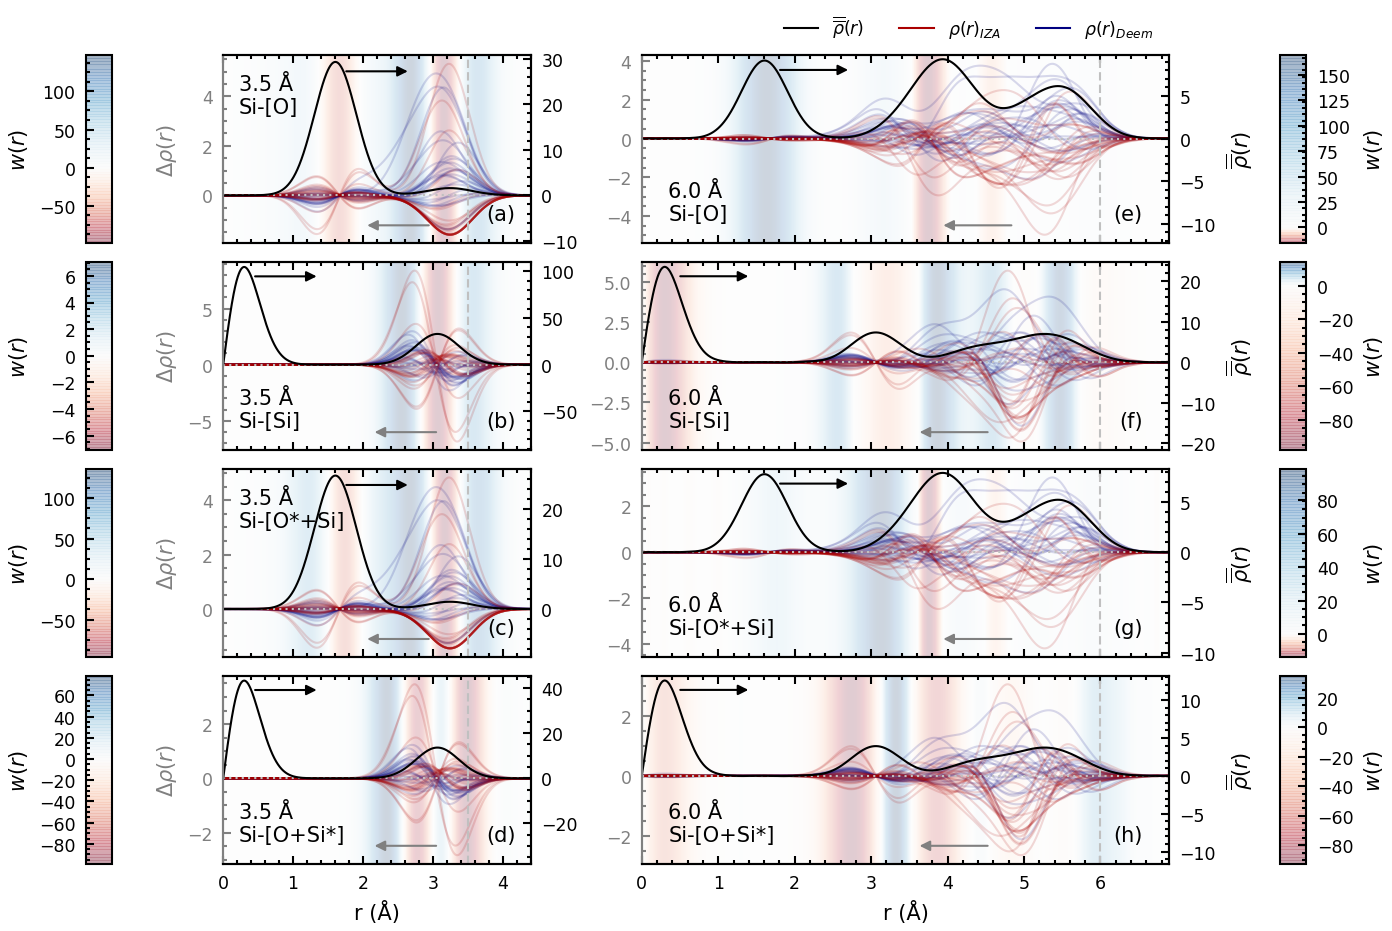

In [55]:
fig = plt.figure(figsize=(10.5, 7.0))
n_cols = 4
n_rows = 4
max_cutoff = np.amax(cutoffs)
width_ratios = [0.05] + [c / max_cutoff for c in cutoffs] + [0.05]

gs = fig.add_gridspec(
    nrows=n_rows, ncols=n_cols,
    width_ratios=width_ratios,
    hspace=0.10, wspace=0.50
)

cb_axes = np.array([[fig.add_subplot(gs[i, j]) for j in (0, -1)] for i in range(0, n_rows)])
data_axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(1, n_cols-1)] for i in range(0, n_rows)]) 

data_axes_mean = np.empty((n_rows, 2), dtype='object')

n_cantons = 2
subfigure_labels = [
    '(a)', '(b)', '(c)', '(d)', 
    '(e)', '(f)', '(g)', '(h)'
]
label_idx = 0
for cdx, cutoff in enumerate(cutoffs):
    svc_dir = f'{model_dir}/{cutoff}/LSVC'
    
    spectrum_type = 'radial'
    spectrum_name = spectrum_type.capitalize()
    
    # Load example SOAPs and compute average over train set
    iza_soaps = utils.load_hdf5(f'{iza_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5')
    iza_train_soaps = iza_soaps[iza_train_idxs]
    iza_ex_soaps = iza_soaps[iza_ex_idxs]
        
    f = h5py.File(f'{deem_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5', 'r')
    deem_330k_dataset = f['0']
    deem_train_soaps = deem_330k_dataset[deem_train_idxs]
    deem_ex_soaps = deem_330k_dataset[deem_ex_idxs[deem_ex_sort_idxs]]
    deem_ex_soaps = deem_ex_soaps[deem_ex_unsort_idxs]
    f.close()
    
    train_soaps = np.vstack((iza_train_soaps, deem_train_soaps))
    n_features = train_soaps.shape[1]
        
    n_features = train_soaps.shape[1]
    feature_groups = extract_species_pair_groups(
        n_features, n_species, 
        spectrum_type='radial',
        combinations=True
    )
    
    # Load basis set projectors
    U = utils.load_hdf5(
        f'../../Processed_Data/DEEM_330k/Data/{cutoff}/basis_projectors.hdf5', datasets=['U']
    )
    U = U[:, 0, :, 0:soap_hyperparameters['max_radial']] # All species, l=0, `max_radial` eigenvectors
    
    # Set up common arguments for real-space density computation
    density_args = dict(
        cutoff=cutoff,
        n_max=basis_hyperparameters['max_radial'],
        r_grid=r_grid[cutoff],
        chunk_size_r=chunk_size_r,
        radial_basis=basis_hyperparameters['radial_basis'],
        gaussian_sigma=basis_hyperparameters['gaussian_sigma_constant'],
        projection_matrix=U
    )
    
    # Compute real-space density
    iza_ex_density = compute_soap_density(
        reshape_soaps(iza_ex_soaps, n_species, soap_hyperparameters['max_radial']),
        **density_args
    )
    
    deem_ex_density = compute_soap_density(
        reshape_soaps(deem_ex_soaps, n_species, soap_hyperparameters['max_radial']),
        **density_args
    )
         
    plot_idx = 0
    for gdx, (group_name, feature_idxs) in enumerate(zip(
        group_names[spectrum_type], feature_groups
    )):
        n_species_plot = group_name.count('+') + 1
        
        if n_species_plot > 1:
            species_slice = slice(None)
        else:
            species_slice = slice(gdx, gdx + 1)
        
        density_args.update(projection_matrix=U[species_slice])
        
        # Load norm scaler
        norm_scaler_attrs = load_json(
            f'{svc_dir}/{n_cantons}-Class/Radial/{group_name}/norm_scaler.json'
        )
        for k, v in norm_scaler_attrs.items():
            if isinstance(v, list):
                norm_scaler_attrs[k] = np.array(v)
        
        norm_scaler = utils.StandardNormScaler()
        norm_scaler.__dict__ = norm_scaler_attrs
        
        # Compute the real-space density of the mean in the StandardNormScaler
        norm_scaler_density = compute_soap_density(
            reshape_soaps(norm_scaler.mean_, n_species_plot, soap_hyperparameters['max_radial']),
            **density_args
        )
                
        # Load SVM model and compute primal coefficients from the dual
        svc_attrs = load_json(
            f'{svc_dir}/{n_cantons}-Class/Radial/{group_name}/svc.json'
        )
        support_idxs = svc_attrs['estimators_'][0]['support_']
        support_vectors = norm_scaler.transform(train_soaps[:, feature_idxs])[support_idxs]
        weights = svc_attrs['estimators_'][0]['dual_coef_'] @ support_vectors
        intercept = svc_attrs['estimators_'][0]['intercept_']
        print(intercept)
#         dr = np.diff(r_grid[cutoff])[0] # dr for GTOs
        dr = 2.0 / len(r_grid[cutoff]) # dr for DVRs
        
        # Compute real-space weights
        weight_density = compute_soap_density(
            reshape_soaps(weights, n_species_plot, soap_hyperparameters['max_radial']),
            **density_args
        )
        
        partial_deem_density = deem_ex_density[:, species_slice, :]
        partial_iza_density = iza_ex_density[:, species_slice, :]
            
        partial_deem_density = (partial_deem_density - norm_scaler_density) / norm_scaler.scale_
        partial_iza_density = (partial_iza_density - norm_scaler_density) / norm_scaler.scale_
        
        norm_scaler_density = norm_scaler_density / norm_scaler.scale_
        
        # Make the radial plot
        group_title = '-'.join(re.findall('[A-Z][a-z]*', group_name))
        species_txt = group_name.split('+')

        for n in range(0, n_species_plot):
            axs = data_axes[plot_idx, cdx]
            pd_min = 1.0E10
            pd_avg = norm_scaler_density[:, n, :].squeeze()
            
            for pd in partial_deem_density:
                axs.plot(
                    r_grid[cutoff], 
                    pd[n], 
#                     np.cumsum(dr*(pd[n])*weight_density[:, n, :].squeeze(), axis=-1)+intercept, 
                    color=color_list[2], 
                    alpha=0.15
                )
                
                if np.amin(pd[n]) < pd_min:
                    pd_min = np.amin(pd[n])
                    min_idx = np.argmin(pd[n])
                    xy_min = np.array([r_grid[cutoff][min_idx], (pd[n])[min_idx]])

            for pd in partial_iza_density:
                axs.plot(
                    r_grid[cutoff], 
                    pd[n],
#                     np.cumsum(dr*(pd[n])*weight_density[:, n, :].squeeze(), axis=-1)+intercept, 
                    color=color_list[1], 
                    alpha=0.15
                )

                if np.amin(pd[n]) < pd_min:
                    pd_min = np.amin(pd[n])
                    min_idx = np.argmin(pd[n])
                    xy_min = np.array([r_grid[cutoff][min_idx], (pd[n])[min_idx]])

            shift = np.array([-0.05, 0.05])
            xy_min = axs.transLimits.transform(xy_min) + shift
            xy_min = axs.transLimits.inverted().transform(xy_min)
            axs.annotate(
                '',
                xy=xy_min,
                xytext=xy_min + np.array([-1.0, 0.0]),
                xycoords=axs.transData,
                textcoords=axs.transData,
                arrowprops=dict(arrowstyle='<|-', color=color_list[5])
            )

            axs_mean = axs.twinx()
            axs_mean.plot(
                r_grid[cutoff], 
                pd_avg, 
#                 np.cumsum(dr*pd_avg*weight_density[:, n, :].squeeze(), axis=-1)+intercept,
                color=color_list[0]
            )
            axs_mean.set_ylim(align_yaxes(axs_mean, axs, 0.0))
            data_axes_mean[plot_idx, cdx] = axs_mean
            max_idx = np.argmax(pd_avg[r_grid[cutoff] < 3.0])
            xy = np.array([r_grid[cutoff][max_idx], pd_avg[max_idx]])
            shift = np.array([0.02, -0.05])
            xy = axs_mean.transLimits.transform(xy) + shift
            xy = axs_mean.transLimits.inverted().transform(xy)
            axs_mean.annotate(
                '',
                xy=xy,
                xytext=xy + np.array([1.0, 0.0]),
                xycoords=axs_mean.transData,
                textcoords=axs_mean.transData,
                arrowprops=dict(arrowstyle='<|-')
            )


            axs.axhline(0.0, linestyle=':', color=color_list[11])
            axs.axvline(cutoff, linestyle='--', color=color_list[11])

            # Background weights
            extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
            w_plot = axs.imshow(
                weight_density[:, n, :], extent=extent, aspect='auto', 
                norm=DivergingNorm(0.0), cmap='RdBu',
                alpha=0.2,
                zorder=0
            )
            
            fig.colorbar(w_plot, cax=cb_axes[plot_idx, cdx], label=r'$w(r)$')

            st = species_txt.copy()
            if n_species_plot > 1:
                st[n] = f'{st[n]}*'

            st = '+'.join(st)

            if cutoff == 3.5 and r_grid[cutoff][max_idx] > 1.0:
                axs.text(
                    0.05, 0.90, f'{cutoff} ' + u'\u00c5\n' + fr'Si-[{st}]',
                    horizontalalignment='left', verticalalignment='top',
                    transform=axs.transAxes
                )
            else:
                axs.text(
                    0.05, 0.10, f'{cutoff} ' + u'\u00c5\n' + fr'Si-[{st}]',
                    horizontalalignment='left', verticalalignment='bottom',
                    transform=axs.transAxes
                )
            
            axs.text(
                0.95, 0.10, subfigure_labels[label_idx],
                horizontalalignment='right', verticalalignment='bottom',
                transform=axs.transAxes
            )

            plot_idx += 1
            label_idx += 1
    
for axs in data_axes[:, 0]:
    axs.set_ylabel(r'$\Delta\rho(r)$', color=color_list[5])

for axs in data_axes[-1, :]:
    axs.set_xlabel('r ' + u'(\u00c5)')
    
for axs in data_axes[0:-1, :].flatten():
    axs.tick_params(labelbottom=False)
    
for axs in data_axes_mean[:, -1]:
    axs.set_ylabel(r'$\overline{\overline{\rho}}(r)$')
    
for axs in data_axes.flatten():
    axs.spines['left'].set_color(color_list[5])
    axs.tick_params(which='both', axis='y', color=color_list[5], labelcolor=color_list[5])
    
# The twinx axis duplicates all spines, so we have to change
# the color here as well
for axs in data_axes_mean.flatten():
    axs.spines['left'].set_color(color_list[5])
    
for caxs in cb_axes[:, 0]:
    caxs.tick_params(which='both', axis='y', right=False, labelright=False, left=True, labelleft=True)
    caxs.yaxis.set_label_position('left')

legend_elements = [
    Line2D(
        [0], [0], 
        color=color_list[0], 
        #label=r'$\frac{1}{2}\left(\overline{\rho}(r)_{Deem} + \overline{\rho}(r)_{IZA}\right)$'
        label=r'$\overline{\overline{\rho}}(r)$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[1], 
        label=r'$\rho(r)_{IZA}$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[2], 
        label=r'$\rho(r)_{Deem}$'
    )
]
data_axes[0, -1].legend(
    handles=legend_elements, 
    loc='lower right', bbox_to_anchor=(1.0, 1.0), 
    ncol=3, columnspacing=2.0
)
fig.align_ylabels()
fig.savefig(f'../../Results/real_space_overlap_{n_cantons}-class_{spectrum_type}.pdf', bbox_inches='tight')

plt.show()

In [56]:
# Check we can reproduce the decision functions
deem_dfs_a = np.loadtxt(
    '../../Processed_Data/DEEM_330k/Data/6.0/LSVC/2-Class/Radial/O+Si/svc_structure_dfs.dat'
)[deem_ex_idxs]
deem_dfs_b = np.dot(norm_scaler.transform(deem_ex_soaps), weights[0].T) + intercept
deem_dfs_c = dr * np.sum(weight_density * partial_deem_density, axis=(-2, -1)) + intercept
deem_dfs_d = dr * np.cumsum(np.sum(weight_density * partial_deem_density, axis=-2), axis=-1) + intercept
for a, b, c, d in zip(deem_dfs_a, deem_dfs_b, deem_dfs_c, deem_dfs_d[:, -1]):
    print(a, b, c, d)

3.4001542050727593 3.4001542050730844 3.3980432224067387 3.3980432224067343
1.5679225742163567 1.5679225742178278 1.5675653830710476 1.5675653830710488
5.4130023013767445 5.413002301368932 5.4089658016856905 5.408965801685697
3.034257382858721 3.034257382858748 3.032687484456382 3.03268748445638
0.06966289655017177 0.06966289654952296 0.07072202915542958 0.07072202915543158
5.1978185120384195 5.1978185120358456 5.194104545025421 5.194104545025428
8.652016484841452 8.652016484845412 8.644899083017823 8.644899083017817
6.411289741099127 6.411289741098383 6.406035330641571 6.406035330641562
3.2965635947984078 3.296563594795562 3.294288414873324 3.294288414873325
6.4161559107139965 6.416155910705335 6.4110074109577075 6.411007410957709
4.036699201182174 4.036699201181122 4.033772511976025 4.033772511976027
3.386688753046789 3.38668875304211 3.384676893509562 3.3846768935095612
8.87550164411286 8.875501644110962 8.868025401583388 8.868025401583397
6.061161481388664 6.061161481387823 6.05675

In [57]:
# Load best 2-Class model
balanced_accuracies = load_json('../../Processed_Data/Models/svc_balanced_accuracy.json')

best_3_model = utils.rank_models(balanced_accuracies, keys=['3.5', '2-Class'])[0]
print('3.5:', best_3_model)

best_6_model = utils.rank_models(balanced_accuracies, keys=['6.0', '2-Class'])[0]
print('6.0:', best_6_model)

# Pick a model to highlight
highlighted_model = '6.0_2-Class_Radial_O'
O_radial_model = (highlighted_model, balanced_accuracies[highlighted_model])
print('Highlighted:', O_radial_model)

print()

# Pick two other models to highlight
power_3_model = '3.5_2-Class_Power_OO'
power_3_model = (power_3_model, balanced_accuracies[power_3_model])

power_6_model = '6.0_2-Class_Power_OO'
power_6_model = (power_6_model, balanced_accuracies[power_6_model])

# models = sorted([best_3_model, best_6_model, O_radial_model], key=lambda item: item[1], reverse=True)
models = sorted([power_3_model, power_6_model, O_radial_model], key=lambda item: item[1], reverse=True)
for model in models:
    print(model)

3.5: ('3.5_2-Class_Power_OO+SiSi', 0.9223358221101856)
6.0: ('6.0_2-Class_Power_OO', 0.9279074720990954)
Highlighted: ('6.0_2-Class_Radial_O', 0.8994520700793485)

('6.0_2-Class_Power_OO', 0.9279074720990954)
('6.0_2-Class_Radial_O', 0.8994520700793485)
('3.5_2-Class_Power_OO', 0.8920412176978765)


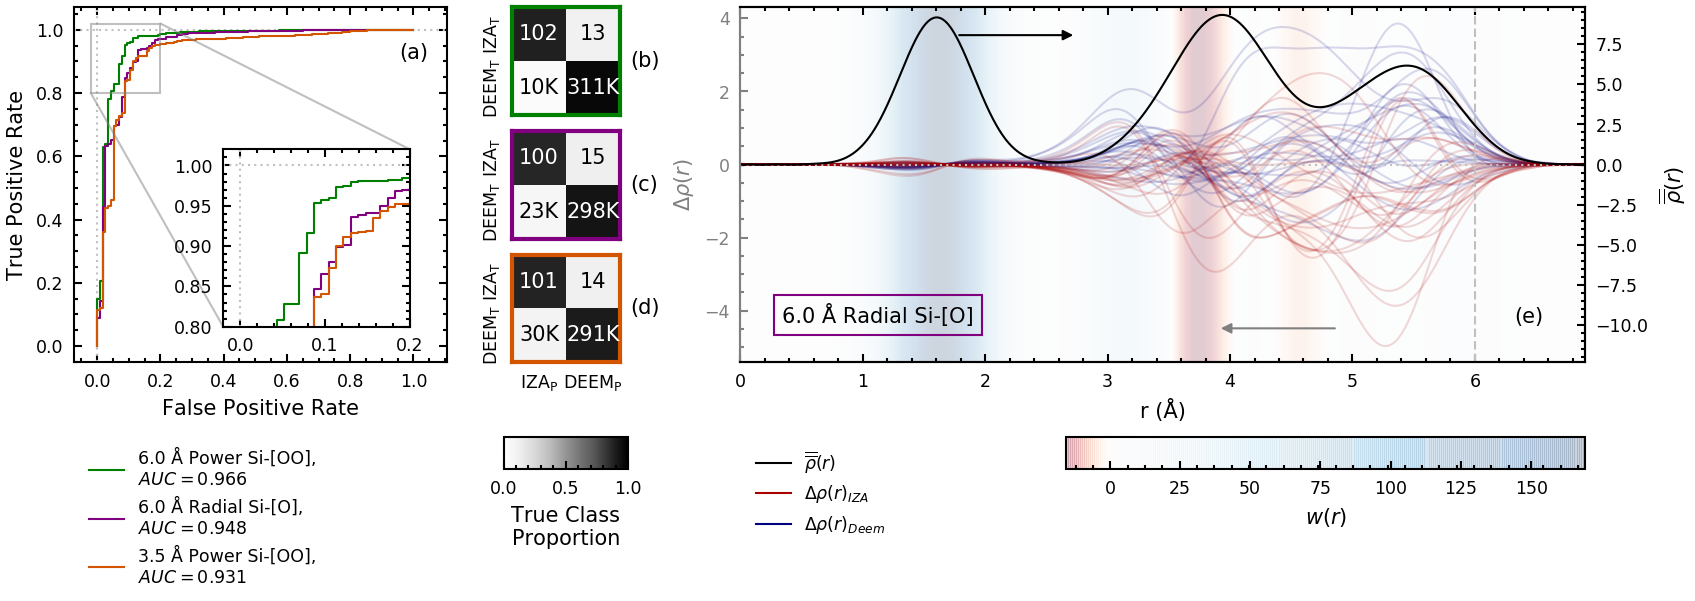

In [58]:
fig = plt.figure(figsize=(13.0, 4.0))

gs = fig.add_gridspec(
    nrows=5, ncols=5,
    width_ratios=(1.0, 0.3, 0.2, 0.75, 1.25),
    height_ratios=(1.0, 1.0, 1.0, 0.4, 0.3),
    wspace=0.05
)

axs = fig.add_subplot(gs[0:-2, -2:])
cb_axs = fig.add_subplot(gs[-1, -1])

roc_axs = fig.add_subplot(gs[0:-2, 0])
roc_axs.set_aspect('equal', anchor='NW')
axs_inset = roc_axs.inset_axes([0.40, 0.10, 0.50, 0.50])
zoom_x = ([-0.02, 0.20])
zoom_y = ([0.80, 1.02])
axs_inset.set_xlim(zoom_x)
axs_inset.set_ylim(zoom_y)
roc_axs.indicate_inset_zoom(axs_inset, label=None)

for ax in (roc_axs, axs_inset):        
    ax.axvline(0.0, color=color_list[11], linestyle=':')
    ax.axhline(1.0, color=color_list[11], linestyle=':')

cm_axes = [fig.add_subplot(gs[i, 1]) for i in range(0, 3)]
cm_cb_axs = fig.add_subplot(gs[-1, 1])

roc_colors = [color_list[3], color_list[4], color_list[7]]
highlighted_model_idx = [model[0] for model in models].index(highlighted_model)
cutoff_selections = [float(model[0].split('_')[0]) for model in models]
spectrum_type_selections = [model[0].split('_')[2] for model in models]
species_pairing_selections = [model[0].split('_')[3] for model in models]

# REAL SPACE DENSITY
cutoff = 6.0
n_cantons = 2
linear_dir = f'{model_dir}/{cutoff}/LSVC'    
spectrum_type = 'radial'
spectrum_name = spectrum_type.capitalize()   
group_name = 'O'
n = group_name.count('+')
n_species_plot = n + 1
gdx = group_names[spectrum_type].index(group_name)

# Load example SOAPs and compute average over train set
iza_soaps = utils.load_hdf5(f'{iza_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5')
iza_train_soaps = iza_soaps[iza_train_idxs]
iza_ex_soaps = iza_soaps[iza_ex_idxs]

f = h5py.File(f'{deem_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5', 'r')
deem_330k_dataset = f['0']
deem_train_soaps = deem_330k_dataset[deem_train_idxs]
deem_ex_soaps = deem_330k_dataset[deem_ex_idxs[deem_ex_sort_idxs]]
deem_ex_soaps = deem_ex_soaps[deem_ex_unsort_idxs]
f.close()

train_soaps = np.vstack((iza_train_soaps, deem_train_soaps))

n_features = train_soaps.shape[1]
feature_groups = extract_species_pair_groups(
    n_features, n_species, 
    spectrum_type='radial',
    combinations=True
)
feature_idxs = feature_groups[gdx]

# Load basis set projectors
U = utils.load_hdf5(
    f'../../Processed_Data/DEEM_330k/Data/{cutoff}/basis_projectors.hdf5', datasets=['U']
)
U = U[:, 0, :, 0:soap_hyperparameters['max_radial']] # All species, l=0, `max_radial` eigenvectors

# Set up common arguments for real-space density computation
density_args = dict(
    cutoff=cutoff,
    n_max=basis_hyperparameters['max_radial'],
    r_grid=r_grid[cutoff],
    chunk_size_r=chunk_size_r,
    radial_basis=basis_hyperparameters['radial_basis'],
    gaussian_sigma=basis_hyperparameters['gaussian_sigma_constant'],
    projection_matrix=U
)

# Compute real-space density
iza_ex_density = compute_soap_density(
    reshape_soaps(iza_ex_soaps, n_species, soap_hyperparameters['max_radial']),
    **density_args
)

deem_ex_density = compute_soap_density(
    reshape_soaps(deem_ex_soaps, n_species, soap_hyperparameters['max_radial']),
    **density_args
)

if n_species_plot > 1:
    species_slice = slice(None)
else:
    species_slice = slice(gdx, gdx + 1)

density_args.update(projection_matrix=U[species_slice])

# Load norm scaler
norm_scaler_attrs = load_json(
    f'{svc_dir}/{n_cantons}-Class/Radial/{group_name}/norm_scaler.json'
)
for k, v in norm_scaler_attrs.items():
    if isinstance(v, list):
        norm_scaler_attrs[k] = np.array(v)

norm_scaler = utils.StandardNormScaler()
norm_scaler.__dict__ = norm_scaler_attrs

# Compute the real-space density of the mean in the StandardNormScaler
norm_scaler_density = compute_soap_density(
    reshape_soaps(norm_scaler.mean_, n_species_plot, soap_hyperparameters['max_radial']),
    **density_args
)

# Load SVM model and compute primal coefficients from the dual
svc_attrs = load_json(
    f'{svc_dir}/{n_cantons}-Class/Radial/{group_name}/svc.json'
)
support_idxs = svc_attrs['estimators_'][0]['support_']
support_vectors = norm_scaler.transform(train_soaps[:, feature_idxs])[support_idxs]
weights = svc_attrs['estimators_'][0]['dual_coef_'] @ support_vectors

# Compute real-space weights
weight_density = compute_soap_density(
    reshape_soaps(weights, n_species_plot, soap_hyperparameters['max_radial']),
    **density_args
)

partial_deem_density = deem_ex_density[:, species_slice, :]
partial_iza_density = iza_ex_density[:, species_slice, :]

partial_deem_density = (partial_deem_density - norm_scaler_density) / norm_scaler.scale_
partial_iza_density = (partial_iza_density - norm_scaler_density) / norm_scaler.scale_

norm_scaler_density = norm_scaler_density / norm_scaler.scale_

# Make the radial plot
group_title = '-'.join(re.findall('[A-Z][a-z]*', group_name))
species_txt = group_name.split('+')
   
pd_min = 1.0E10
pd_avg = norm_scaler_density[:, n, :].squeeze()

for pd in partial_deem_density:
    axs.plot(
        r_grid[cutoff], 
        pd[n], 
        color=color_list[2], 
        alpha=0.15
    )

    if np.amin(pd[n]) < pd_min:
        pd_min = np.amin(pd[n])
        min_idx = np.argmin(pd[n])
        xy_min = np.array([r_grid[cutoff][min_idx], (pd[n])[min_idx]])

for pd in partial_iza_density:
    axs.plot(
        r_grid[cutoff], 
        pd[n], 
        color=color_list[1], 
        alpha=0.15
    )

    if np.amin(pd[n]) < pd_min:
        pd_min = np.amin(pd[n])
        min_idx = np.argmin(pd[n])
        xy_min = np.array([r_grid[cutoff][min_idx], (pd[n])[min_idx]])

shift = np.array([-0.05, 0.05])
xy_min = axs.transLimits.transform(xy_min) + shift
xy_min = axs.transLimits.inverted().transform(xy_min)
axs.annotate(
    '',
    xy=xy_min,
    xytext=xy_min + np.array([-1.0, 0.0]),
    xycoords=axs.transData,
    textcoords=axs.transData,
    arrowprops=dict(arrowstyle='<|-', color=color_list[5])
)

axs_mean = axs.twinx()
axs_mean.plot(
    r_grid[cutoff], 
    pd_avg, 
    color=color_list[0]
)
axs_mean.set_ylim(align_yaxes(axs_mean, axs, 0.0))
max_idx = np.argmax(pd_avg[r_grid[cutoff] < 3.0])
xy = np.array([r_grid[cutoff][max_idx], pd_avg[max_idx]])
shift = np.array([0.02, -0.05])
xy = axs_mean.transLimits.transform(xy) + shift
xy = axs_mean.transLimits.inverted().transform(xy)
axs_mean.annotate(
    '',
    xy=xy,
    xytext=xy + np.array([1.0, 0.0]),
    xycoords=axs_mean.transData,
    textcoords=axs_mean.transData,
    arrowprops=dict(arrowstyle='<|-')
)

axs.axhline(0.0, linestyle=':', color=color_list[11])
axs.axvline(cutoff, linestyle='--', color=color_list[11])

# Background weights
extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
w_plot = axs.imshow(
    weight_density[:, n, :], extent=extent, aspect='auto', 
    norm=DivergingNorm(0.0), cmap='RdBu',
    alpha=0.2,
    zorder=0
)
fig.colorbar(w_plot, cax=cb_axs, label=r'$w(r)$', orientation='horizontal')

st = species_txt.copy()
if n > 1:
    st[n] = f'{st[n]}*'

st = '+'.join(st)

axs.text(
    0.05, 0.10, f'{cutoff} ' + u'\u00c5 Radial ' + fr'Si-[{st}]',
    horizontalalignment='left', verticalalignment='bottom',
    transform=axs.transAxes,
    bbox=dict(edgecolor=roc_colors[highlighted_model_idx], fill=False)
)

axs.text(
    0.95, 0.10, '(e)',
    horizontalalignment='right', verticalalignment='bottom',
    transform=axs.transAxes
)

axs.set_ylabel(r'$\Delta\rho(r)$', color=color_list[5])
axs.set_xlabel('r ' + u'(\u00c5)')

axs.spines['left'].set_color(color_list[5])
axs.tick_params(which='both', axis='y', color=color_list[5], labelcolor=color_list[5])

axs_mean.set_ylabel(r'$\overline{\overline{\rho}}(r)$')

# The twinx axis duplicates all spines, so we have to change
# the color here as well
axs_mean.spines['left'].set_color(color_list[5])

legend_elements = [
    Line2D(
        [0], [0], 
        color=color_list[0], 
        label=r'$\overline{\overline{\rho}}(r)$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[1], 
        label=r'$\Delta\rho(r)_{IZA}$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[2], 
        label=r'$\Delta\rho(r)_{Deem}$'
    )
]

axs.legend(
    handles=legend_elements, 
    loc='upper left', bbox_to_anchor=(0.0, -0.2), 
)

# ROC CURVES AND CONFUSION MATRICES
roc_cycle = (cycler(color=roc_colors))

vmin = 0.0
vmax = 1.0
cm_norm = Normalize(vmin=vmin, vmax=vmax)

for ax in (roc_axs, axs_inset):
    ax.set_prop_cycle(roc_cycle)

legend_lines = []
for idx, (cutoff, spectrum_type, species_pairing, subfigure_label) in enumerate(zip(
    cutoff_selections, spectrum_type_selections, species_pairing_selections,
    ['(b)', '(c)', '(d)']
)):
    roc_line_pairs = []
    spectrum_name = spectrum_type.capitalize()
        
    data_dir = f'LSVC/2-Class/{spectrum_name}/{species_pairing}'

    dfs_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
    dfs_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

    test_dfs = np.concatenate((dfs_iza[iza_test_idxs], dfs_deem[deem_test_idxs]))
    
    fpr, tpr, thresholds = roc_curve(
        test_cantons[2], 
        test_dfs, 
        pos_label=2
    )
    auc = roc_auc_score(
        test_cantons[2],
        test_dfs,
        average='macro'
    )

    #print(f'{cutoff}-{spectrum_name}-{species_pairing}: {auc}')
    #print(f'{cutoff}-{spectrum_name}-{species_pairing}: {-np.log10(1.0-auc)}')

    line_pair = []
    for ax in (roc_axs, axs_inset):
        line = ax.plot(
            fpr, tpr, 
            label=f'{cutoff} ' + u'\u00c5 ' + f'{spectrum_name} Si-[{species_pairing}],\n$AUC={{{auc:0.3f}}}$'
        )
        line_pair.extend(line)
    roc_line_pairs.append(line_pair)
    
    for line_pair in roc_line_pairs:
        legend_lines.append(line_pair[0])
        
    #axs[cutoff].set_xlim([-0.01, 0.2])
    roc_axs.set_ylabel('True Positive Rate')
    roc_axs.set_xlabel('False Positive Rate')
    
    # CONFUSION MATRIX  
    predicted_cantons_iza = np.loadtxt(
        f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
    )

    predicted_cantons_deem = np.loadtxt(
        f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
    )
        
    predicted_test_cantons = np.concatenate((
        predicted_cantons_iza[iza_test_idxs], 
        predicted_cantons_deem[deem_test_idxs]
    ))
    
    matrix_test = confusion_matrix(test_cantons[n_cantons], predicted_test_cantons)


    matrix_ref = np.zeros((2, 2), dtype=int)
    
    for i in range(0, 2):
        matrix_ref[i, i] = np.count_nonzero(test_cantons[2] == (i + 1))

    matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]

    mat_axs = cm_axes[idx]
    matshow = mat_axs.imshow(matrix_norm, cmap='Greys', norm=cm_norm)
        
    for spine in mat_axs.spines.values():
        spine.set_color(line[0].get_color())
        spine.set_linewidth(2.0)

    for i in range(0, 2):
        for j in range(0, 2):
            if matrix_norm[i, j] > (0.5 * vmax):
                text_color = 'w'
            else:
                text_color = 'k'

            if len(str(matrix_test[i, j])) > 3:

                # This isn't a very 'robust' way of doing this,
                # but since we only go up to 6 digits, this should work
                # (we do this shortening only if the number has 6 digits)
                box_number_str = str(round(matrix_test[i, j], -3))
                box_number_str = box_number_str[0:-3] + 'K'
            else:
                box_number_str = f'{matrix_test[i, j]:d}'

            mat_axs.text(
                j, i, box_number_str,
                horizontalalignment='center', verticalalignment='center',
                color=text_color
            )

    mat_axs.set_xticks(np.arange(0, 2))
    mat_axs.set_yticks(np.arange(0, 2))

    if idx == 2:
        mat_axs.set_xticklabels([tl + r'$_\mathrm{P}$' for tl in ticklabels[2]])
        mat_axs.tick_params(
            axis='x', which='both',
            bottom=False, top=False,
            labelbottom=True, labeltop=False
        )
    else:
        mat_axs.tick_params(
            axis='x', which='both',
            bottom=False, top=False,
            labelbottom=False, labeltop=False
        )

    mat_axs.set_yticklabels([tl + r'$_\mathrm{T}$' for tl in ticklabels[2]], rotation=90, verticalalignment='center')
    mat_axs.tick_params(
        axis='y', which='both',
        left=False, right=False,
        labelleft=True, labelright=False
    )
    
    mat_axs.text(
        1.1, 0.5, subfigure_label,
        horizontalalignment='left', verticalalignment='center',
        transform=mat_axs.transAxes
    )
    
roc_axs.text(
    0.95, 0.90, '(a)',
    horizontalalignment='right', verticalalignment='top',
    transform=roc_axs.transAxes
)

sm = ScalarMappable(norm=cm_norm, cmap='Greys')
cm_cb = fig.colorbar(sm, cax=cm_cb_axs, orientation='horizontal')
cm_cb.set_label('True Class\nProportion')
    
roc_axs.legend(loc='upper left', bbox_to_anchor=(0.0, -0.2))

fig.align_ylabels()
fig.savefig(f'../../Results/real_space_density_summary.pdf', bbox_inches='tight')

plt.show()